# Lung Disease Prediction from X-ray Images

HDA Project 21/22

German Elizaveta, Andrii Kliachkin

In [298]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import image_dataset_from_directory
from keras.models import Sequential, Model, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, LSTM, Input, Conv2DTranspose, MaxPool2D, UpSampling2D, Reshape, LeakyReLU, Lambda
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import seaborn as sns
from sklearn.metrics import confusion_matrix
from skimage import data, img_as_float
from skimage import exposure
import random
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, plot_precision_recall_curve

In [2]:
def plot_loss(history):
    plt.figure(figsize=(6,3))
    plt.plot(history.epoch,history.history['loss'])
    plt.plot(history.epoch,history.history['val_loss'])
    plt.legend(['training', 'validation'])
    plt.title('loss')

def plot_accuracy(history):
    plt.figure(figsize=(6,3))
    plt.plot(history.epoch,history.history['accuracy'])
    plt.plot(history.epoch,history.history['val_accuracy'])
    plt.legend(['training', 'validation'])
    plt.title('accuracy')

In [3]:
def performance_measures(model, X_test, y_test):
    y_pred = model.predict(X_test, batch_size=32, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)
    
    recall = recall_score(y_test, y_pred_bool, average='macro')
    precision = precision_score(y_test, y_pred_bool, average='macro')
    f1 = f1_score(y_test, y_pred_bool, average='macro')
    print('Recall score: %.2f%%' % (recall*100))
    print('Precision score: %.2f%%' % (precision*100))
    print('F1 score: %.2f%%' % (f1*100))
    
    return recall, precision, f1

In [4]:
def conf_matrix(model, X_test, y_test):
  
  # Predict
    y_pred = model.predict(X_test, batch_size=32, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)
    y_test_bool = y_test #, axis=1)
    
  # Confusion matrix
    
    labels = ('normal', 'covid', 'pneumonia')
    df_confusion = confusion_matrix(y_true = y_test_bool, y_pred = y_pred_bool)
    precision = np.round(df_confusion/df_confusion.sum(axis = 0), 2)
    recall = np.round((df_confusion.T/df_confusion.sum(axis = 1)).T, 2)
    
    matplotlib.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), frameon = False)
    sns.heatmap(recall, cmap='YlGnBu', vmin=0.0, vmax=1.0, # cmap = 'BuPu'
                annot=True, ax=ax[0])
    sns.heatmap(precision, cmap='YlGnBu', vmin=0.0, vmax=1.0,
                annot=True, ax=ax[1])
    
    ax[0].set_title('Recall', fontsize = 14)
    ax[1].set_title('Precision', fontsize = 14)
    ax[0].set_yticklabels(labels, va="center")
    ax[1].set_yticklabels(labels, va="center")
    ax[0].set_xticklabels(labels, va="center")
    ax[1].set_xticklabels(labels, va="center")
    
    ax[0].set_ylabel("True value", fontsize = 12)
    ax[0].set_xlabel("Predicted value", fontsize = 12)
    ax[1].set_ylabel("True value", fontsize = 12)
    ax[1].set_xlabel("Predicted value", fontsize = 12)

    plt.show()

In [272]:
def normalize_img(image):
    return tf.cast(image, tf.float32) / 255.

def show_image(x):
    x = np.squeeze(x)
    plt.imshow(x, cmap='gray')

def show_img(data, labels):   
    plt.figure(figsize=(8, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        idx = random.randint(0, len(data))
        show_image(data[idx])
        plt.title([labels[idx]])
    plt.savefig('images.png')

## Pre-processing

### Load data

In [6]:
img_path = 'covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'

In [7]:
def load_image(filename: str, sizeX: int=256, sizeY: int=256):
    img = cv2.imread(filename)
    if img is None:
        pass
    else:
        img = np.array(cv2.resize(img, (sizeX, sizeY)), dtype='float32')
    return img

In [8]:
def load_data_os(data_path: str):
    images_covid = [load_image('/'.join([img_path, 'covid', fn])) for fn in os.listdir('covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid') if fn != '.DS_Store']
    images_pneum = [load_image('/'.join([data_path, 'pneumonia', fn])) for fn in os.listdir('covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia') if fn != '.DS_Store']
    images_norm = [load_image('/'.join([data_path, 'normal', fn])) for fn in os.listdir('covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/normal') if fn != '.DS_Store']
    images = np.array(images_norm + images_covid + images_pneum)
    classes = list(np.zeros(np.shape(images_norm)[0])) + list(np.ones(np.shape(images_covid)[0])) + list(2 * np.ones(np.shape(images_pneum)[0]))
    return images, np.array(classes)

In [9]:
X, y = load_data_os(img_path)
X /= 256.
print(X.shape)
print(y.shape)

(4575, 256, 256, 3)
(4575,)


In [10]:
print('covid:', len(y[y==1]))
print('pneumonia:', len(y[y==2]))
print('normal:', len(y[y==0]))

covid: 1525
pneumonia: 1525
normal: 1525


### Contrasting

In [289]:
def contrasting(data, contrast):
    imgs = []
    for i in range(0, len(data)):
        img = contrast(data[i])
        imgs.append(img)
    X = np.array(imgs)
    return X

In [13]:
def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    return img_rescale

In [14]:
def hist_equalization(img):
    # Equalization
    img_eq = exposure.equalize_hist(img)
    
    return img_eq

In [15]:
def adaptive_equalization(img):
    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    
    return img_adapteq

In [295]:
def gray(data):
    imgs = []
    for i in range(0, len(data)):
        img = np.array(tf.image.rgb_to_grayscale(data[i]))
        imgs.append(img)
    X = np.array(imgs)
    return X

### Train-test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [18]:
def labeling(y):

    y_labels = []

    for i in range(len(y)):
        if y[i] == 1:
            y_labels.append('covid')
        else:
            if y[i] == 2:
                y_labels.append('pneumonia')
            else:
                y_labels.append('normal')
    
    return y_labels

In [19]:
y_train_labels = labeling(y_train)
y_val_labels = labeling(y_val)
y_test_labels = labeling(y_test)

In [20]:
print(len(y_val[y_val==0]))
print(len(y_val[y_val==1]))
print(len(y_val[y_val==2]))

243
230
213


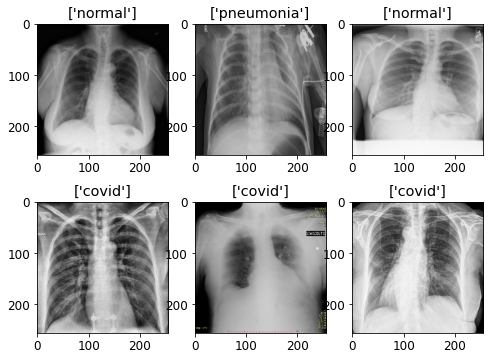

In [278]:
show_img(X_train, y_train_labels)

## Models

### Callbacks

In [28]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [125]:
earlystop = EarlyStopping(monitor='val_loss',
                          patience=2,
                          verbose=1,
                          min_delta=0.0005,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=2,
                              verbose=1,
                              mode='max',
                              min_lr=5e-15)

model_checkpoint = ModelCheckpoint(filepath='/tmp/checkpoint',
                                  save_weights_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  save_best_only=True)

time_callback = TimeHistory()

n_epochs = 30
batch_size = 32
num_classes = 3

### Base CNN Model

In [30]:
# Loading model - in order to skip the training

path = 'covid19-pneumonia-normal-chest-xraypa-dataset/'

# Load json
json_file = open(os.path.join(path, 'Model_base.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
model_base = model_from_json(loaded_model_json)

# Load weights
model_base.load_weights(os.path.join(path, 'Model_base.h5'))

# Compile model
model_base.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summary of the model
print(model_base.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 262144)            0         
                                                                 
 dense_14 (Dense)            (None, 3)                 786435    
                                                                 
Total params: 786,883
Trainable params: 786,883
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
callbacks_base = [earlystop, reduce_lr, model_checkpoint, time_callback]

In [35]:
model_base = models.Sequential([
            layers.Conv2D(filters=16, kernel_size=(3,3), activation = 'relu', padding = 'same', input_shape=(256, 256, 3)),
            layers.MaxPooling2D((2,2)),
            layers.Flatten(),
            layers.Dense(3)])

print(model_base.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 dense_1 (Dense)             (None, 3)                 786435    
                                                                 
Total params: 786,883
Trainable params: 786,883
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
model_base.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [37]:
history_base = model_base.fit(X_train, y_train, 
                      epochs= n_epochs, 
                      callbacks = callbacks_base, 
                      batch_size = batch_size,
                      validation_data=(X_val, y_val))

Epoch 1/30
101/101 [==============================] - 42s 408ms/step - loss: 0.8041 - accuracy: 0.6964 - val_loss: 0.5187 - val_accuracy: 0.8003 - lr: 1.0000e-04
Epoch 2/30
101/101 [==============================] - 50s 488ms/step - loss: 0.4296 - accuracy: 0.8470 - val_loss: 0.4795 - val_accuracy: 0.7945 - lr: 1.0000e-04
Epoch 3/30
101/101 [==============================] - 54s 534ms/step - loss: 0.3763 - accuracy: 0.8735 - val_loss: 0.3689 - val_accuracy: 0.8688 - lr: 1.0000e-04
Epoch 4/30
101/101 [==============================] - 51s 501ms/step - loss: 0.3347 - accuracy: 0.8941 - val_loss: 0.3353 - val_accuracy: 0.9023 - lr: 1.0000e-04
Epoch 5/30
101/101 [==============================] - 51s 504ms/step - loss: 0.3372 - accuracy: 0.8776 - val_loss: 0.5792 - val_accuracy: 0.7085 - lr: 1.0000e-04
Epoch 6/30
101/101 [==============================] - ETA: 0s - loss: 0.3185 - accuracy: 0.8957
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
101/101 [====

In [42]:
###### SAVE MODEL

model_json = model_base.to_json()
with open(os.path.join(path, 'Model_base.json'), "w") as json_file:
     json_file.write(model_json)

model_base.save_weights(os.path.join(path, 'Model_base.h5'))
print("Model Saved")

Model Saved


In [114]:
hist_base = pd.DataFrame(history_base.history)
hist_base_csv = 'hist_base.csv'
with open(hist_base_csv, mode = 'w') as f:
    hist_base.to_csv(f)

22/22 - 2s - loss: 0.3088 - accuracy: 0.9068 - 2s/epoch - 94ms/step


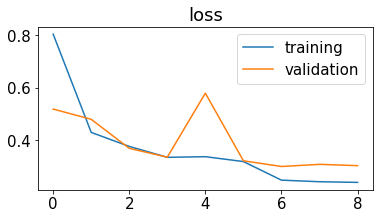

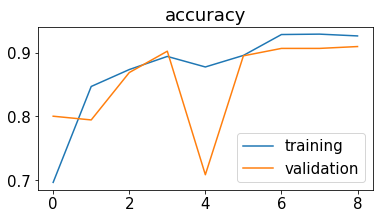

In [43]:
plot_loss(history_base)

plot_accuracy(history_base)

scores_base = model_base.evaluate(X_test, y_test, verbose=2)

In [44]:
# Temporal complexity measures
time_base = time_callback.times
time_base_per_epoch = np.round(np.mean(time_base))
time_base_total = np.round(np.sum(time_base))

print('Running time:', time_base_per_epoch, 'seconds per epoch')
print('Total running time:', time_base_total, 'seconds for ', len(history_base.epoch), 'epochs')

Running time: 47.0 seconds per epoch
Total running time: 427.0 seconds for  9 epochs


In [122]:
time_base_s = pd.DataFrame(time_base)
time_base_csv = 'time_base.csv'
with open(time_base_csv, mode = 'w') as f:
    time_base_s.to_csv(f)

test accuracy: 90.68%
22/22 [==============================] - 2s 104ms/step


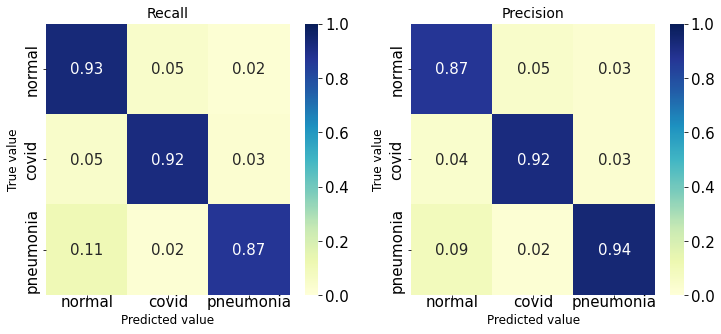

In [45]:
# Accuracy 
print('test %s: %.2f%%' % (model_base.metrics_names[1], scores_base[1]*100))
accuracy_base = np.round(scores_base[1]*100)

# Confusion matrix: Recall vs. Precision
conf_matrix(model_base, X_test, y_test)

In [46]:
recall_base, precision_base, f1_base = performance_measures(model_base, X_test, y_test)

22/22 [==============================] - 2s 98ms/step
Recall score: 90.59%
Precision score: 91.03%
F1 score: 90.73%


### Base CNN with augmented data

In [47]:
# Loading model - in order to skip the training

# Load json
json_file = open(os.path.join(path, 'Model_base_aug.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
model_base_aug = model_from_json(loaded_model_json)

# Load weights
model_base_aug.load_weights(os.path.join(path, 'Model_base_aug.h5'))

# Compile model
model_base_aug.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summary of the model
print(model_base_aug.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 262144)            0         
                                                                 
 dense_17 (Dense)            (None, 3)                 786435    
                                                                 
Total params: 786,883
Trainable params: 786,883
Non-trainable params: 0
_________________________________________________________________
None


In [126]:
datagen = ImageDataGenerator(
                    featurewise_center=False,
                    featurewise_std_normalization=False,
                    rotation_range=10,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True)

In [127]:
callbacks_base = [earlystop, reduce_lr, model_checkpoint, time_callback]

In [128]:
model_base_aug = models.Sequential([
            layers.Conv2D(filters=16, kernel_size=(3,3), activation = 'relu', padding = 'same', input_shape=(256, 256, 3)),
            layers.MaxPooling2D((2,2)),
            layers.Flatten(),
            layers.Dense(3)])

print(model_base_aug.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_129 (Conv2D)         (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 262144)            0         
                                                                 
 dense_50 (Dense)            (None, 3)                 786435    
                                                                 
Total params: 786,883
Trainable params: 786,883
Non-trainable params: 0
_________________________________________________________________
None


In [129]:
model_base_aug.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [130]:
nb_train_samples = X_train.shape[0]
nb_validation_samples = X_val.shape[0]

history_base_aug = model_base_aug.fit(
               datagen.flow(X_train, y_train, batch_size=batch_size),
               steps_per_epoch = nb_train_samples//batch_size,
               epochs = n_epochs,
               callbacks = callbacks_base,
               validation_data = datagen.flow(X_val, y_val),
               validation_steps = nb_validation_samples//batch_size)

Epoch 1/30
100/100 [==============================] - 124s 1s/step - loss: 0.8748 - accuracy: 0.6356 - val_loss: 0.6448 - val_accuracy: 0.7426 - lr: 1.0000e-04
Epoch 2/30
100/100 [==============================] - 124s 1s/step - loss: 0.6468 - accuracy: 0.7445 - val_loss: 0.5752 - val_accuracy: 0.7738 - lr: 1.0000e-04
Epoch 3/30
100/100 [==============================] - 101s 1s/step - loss: 0.5819 - accuracy: 0.7744 - val_loss: 0.5638 - val_accuracy: 0.7723 - lr: 1.0000e-04
Epoch 4/30
100/100 [==============================] - 106s 1s/step - loss: 0.5355 - accuracy: 0.7968 - val_loss: 0.5671 - val_accuracy: 0.7887 - lr: 1.0000e-04
Epoch 5/30
100/100 [==============================] - 102s 1s/step - loss: 0.5624 - accuracy: 0.7940 - val_loss: 0.6064 - val_accuracy: 0.7634 - lr: 1.0000e-04
Epoch 00005: early stopping


In [131]:
###### SAVE MODEL

model_json = model_base_aug.to_json()
with open(os.path.join(path, 'Model_base_aug.json'), "w") as json_file:
     json_file.write(model_json)

model_base_aug.save_weights(os.path.join(path, 'Model_base_aug.h5'))
print("Model Saved")

Model Saved


In [132]:
hist_base_aug = pd.DataFrame(history_base_aug.history)
hist_base_aug_csv = 'hist_base_aug.csv'
with open(hist_base_aug_csv, mode = 'w') as f:
    hist_base_aug.to_csv(f)

22/22 - 3s - loss: 0.4981 - accuracy: 0.8108 - 3s/epoch - 149ms/step


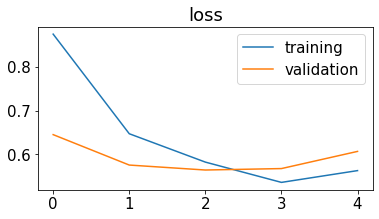

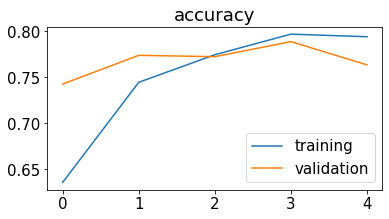

In [133]:
plot_loss(history_base_aug)

plot_accuracy(history_base_aug)

scores_base_aug = model_base_aug.evaluate(X_test, y_test, verbose=2)

In [134]:
# Temporal complexity measures
time_base_aug = time_callback.times
time_base_aug_per_epoch = np.round(np.mean(time_base_aug))
time_base_aug_total = np.round(np.sum(time_base_aug))

print('Running time:', time_base_aug_per_epoch, 'seconds per epoch')
print('Total running time:', time_base_aug_total, 'seconds for', len(history_base_aug.epoch), 'epochs')

Running time: 112.0 seconds per epoch
Total running time: 558.0 seconds for 5 epochs


In [135]:
time_base_aug_s = pd.DataFrame(time_base_aug)
time_base_aug_csv = 'time_base_aug.csv'
with open(time_base_aug_csv, mode = 'w') as f:
    time_base_aug_s.to_csv(f)

test accuracy: 81.08%
22/22 [==============================] - 2s 104ms/step


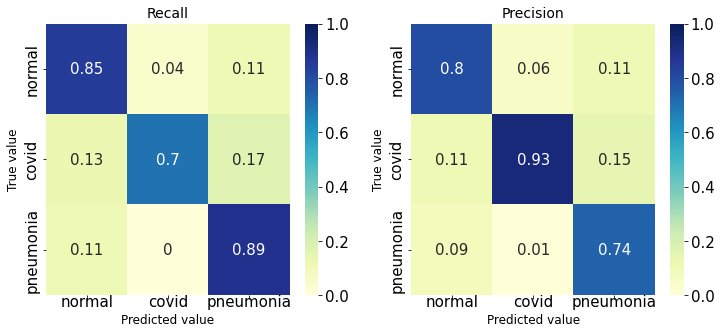

In [136]:
# Accuracy 
print('test %s: %.2f%%' % (model_base_aug.metrics_names[1], scores_base_aug[1]*100))
accuracy_base_aug = np.round(scores_base_aug[1]*100)

# Confusion matrix: Recall vs. Precision
conf_matrix(model_base_aug, X_test, y_test)

In [137]:
recall_base_aug, precision_base_aug, f1_base_aug = performance_measures(model_base_aug, X_test, y_test)

22/22 [==============================] - 3s 110ms/step
Recall score: 81.01%
Precision score: 82.55%
F1 score: 80.99%


### AlexNet

In [298]:
# Loading model - in order to skip the training

# Load json
json_file = open(os.path.join(path, 'Model_alexnet.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
model_alexnet = model_from_json(loaded_model_json)

# Load weights
model_alexnet.load_weights(os.path.join(path, 'Model_alexnet.h5'))

# Compile model
model_alexnet.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summary of the model
print(model_alexnet.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                     

In [100]:
callbacks_alexnet = [earlystop, reduce_lr, model_checkpoint, time_callback]

In [101]:
model_alexnet = models.Sequential([
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

print(model_alexnet.summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_124 (Conv2D)         (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_125 (Conv2D)         (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                     

In [102]:
model_alexnet.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.optimizers.SGD(learning_rate=0.001), 
              metrics=['accuracy'])

In [103]:
history_alexnet = model_alexnet.fit(X_train, y_train,
                      batch_size = batch_size,
                      epochs = n_epochs,
                      callbacks = callbacks_alexnet,
                      validation_data = (X_val, y_val))

Epoch 1/30
101/101 [==============================] - 298s 3s/step - loss: 1.1535 - accuracy: 0.6846 - val_loss: 1.1678 - val_accuracy: 0.3105 - lr: 0.0010
Epoch 2/30
101/101 [==============================] - 275s 3s/step - loss: 0.6665 - accuracy: 0.7864 - val_loss: 1.3911 - val_accuracy: 0.4271 - lr: 0.0010
Epoch 3/30
101/101 [==============================] - 289s 3s/step - loss: 0.5508 - accuracy: 0.8245 - val_loss: 1.1650 - val_accuracy: 0.5612 - lr: 0.0010
Epoch 4/30
101/101 [==============================] - 299s 3s/step - loss: 0.4769 - accuracy: 0.8445 - val_loss: 0.4471 - val_accuracy: 0.8601 - lr: 0.0010
Epoch 5/30
101/101 [==============================] - 273s 3s/step - loss: 0.4214 - accuracy: 0.8663 - val_loss: 0.3967 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 6/30
101/101 [==============================] - 281s 3s/step - loss: 0.4097 - accuracy: 0.8616 - val_loss: 0.3263 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 7/30
101/101 [==============================] - 306s 3s/st

In [104]:
# SAVE MODEL

model_json = model_alexnet.to_json()
with open(os.path.join(path, 'Model_alexnet.json'), "w") as json_file:
     json_file.write(model_json)

model_alexnet.save_weights(os.path.join(path, 'Model_alexnet.h5'))

print("Model Saved")

Model Saved


In [111]:
hist_alexnet = pd.DataFrame(history_alexnet.history)
hist_alexnet_csv = 'hist_alexnet.csv'
with open(hist_alexnet_csv, mode = 'w') as f:
    hist_alexnet.to_csv(f)

22/22 - 12s - loss: 0.2507 - accuracy: 0.9229 - 12s/epoch - 551ms/step


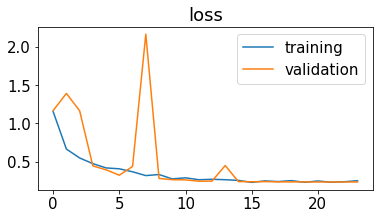

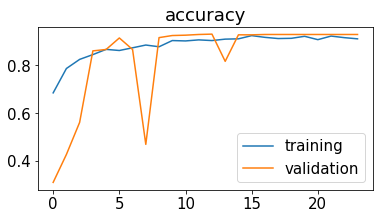

In [105]:
plot_loss(history_alexnet)

plot_accuracy(history_alexnet)

scores_alexnet = model_alexnet.evaluate(X_test, y_test, verbose=2)

In [108]:
# Temporal complexity measures
time_alexnet = time_callback.times
time_alexnet_per_epoch = np.round(np.mean(time_alexnet))
time_alexnet_total = np.round(np.sum(time_alexnet))

print('Running time:', time_alexnet_per_epoch, 'seconds per epoch')
print('Total running time:', time_alexnet_total, 'seconds for', len(history_alexnet.epoch), 'epochs')

Running time: 281.0 seconds per epoch
Total running time: 6734.0 seconds for 24 epochs


In [118]:
time_alexnet = pd.DataFrame(time_alexnet)
time_alexnet_csv = 'time_alexnet.csv'
with open(time_alexnet_csv, mode = 'w') as f:
    time_alexnet.to_csv(f)

test accuracy: 92.29%
22/22 [==============================] - 11s 493ms/step


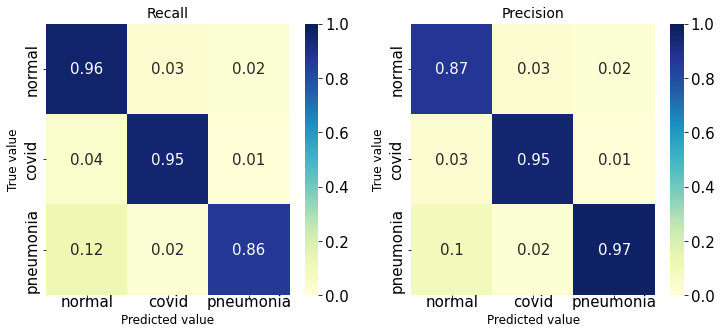

In [109]:
# Accuracy 
print('test %s: %.2f%%' % (model_alexnet.metrics_names[1], scores_alexnet[1]*100))
accuracy_alexnet = np.round(scores_alexnet[1]*100)

# Confusion matrix: Recall vs. Precision
conf_matrix(model_alexnet, X_test, y_test)

In [119]:
recall_alexnet, precision_alexnet, f1_alexnet = performance_measures(model_alexnet, X_test, y_test)

22/22 [==============================] - 17s 774ms/step
Recall score: 92.13%
Precision score: 92.86%
F1 score: 92.31%


### VGG-16

In [51]:
# Loading model - in order to skip the training

# Load json
json_file = open(os.path.join(path, 'Model_vgg16.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
model_vgg16 = model_from_json(loaded_model_json)

# Load weights
model_vgg16.load_weights(os.path.join(path, 'Model_vgg16.h5'))

# Compile model
model_vgg16.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summary of the model
print(model_vgg16.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_40 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 conv2d_42 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                 

In [138]:
earlystop = EarlyStopping(monitor='val_loss',
                          patience=3,
                          verbose=1,
                          min_delta=0.0005,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=2,
                              verbose=1,
                              mode='max',
                              min_lr=5e-15)

model_checkpoint = ModelCheckpoint(filepath='/tmp/checkpoint',
                                  save_weights_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  save_best_only=True)

time_callback = TimeHistory()

n_epochs = 30
batch_size = 32
num_classes = 3

In [139]:
callbacks_vgg16 = [earlystop, reduce_lr, model_checkpoint, time_callback]

In [140]:
model_vgg16 = models.Sequential([  
    layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu", input_shape=(256, 256, 3)),
    layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    layers.Flatten(),
    layers.Dense(units=64,activation="relu"), #4096
    layers.Dense(units=64,activation="relu"), #4096
    layers.Dense(units=num_classes)])

print(model_vgg16.summary())

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130 (Conv2D)         (None, 256, 256, 32)      896       
                                                                 
 conv2d_131 (Conv2D)         (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_132 (Conv2D)         (None, 128, 128, 64)      18496     
                                                                 
 conv2d_133 (Conv2D)         (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                

In [141]:
model_vgg16.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer=tf.optimizers.Adam(learning_rate=1e-4), 
                    metrics=['accuracy'])

In [142]:
history_vgg16 = model_vgg16.fit(X_train, y_train,
                                epochs = n_epochs,
                                batch_size = batch_size,
                                callbacks = callbacks_vgg16,
                                validation_data=(X_val, y_val))

Epoch 1/30
101/101 [==============================] - 945s 9s/step - loss: 0.7688 - accuracy: 0.6349 - val_loss: 0.5740 - val_accuracy: 0.7566 - lr: 1.0000e-04
Epoch 2/30
101/101 [==============================] - 939s 9s/step - loss: 0.4615 - accuracy: 0.8245 - val_loss: 0.4158 - val_accuracy: 0.8469 - lr: 1.0000e-04
Epoch 3/30
101/101 [==============================] - 931s 9s/step - loss: 0.3557 - accuracy: 0.8738 - val_loss: 0.3453 - val_accuracy: 0.8936 - lr: 1.0000e-04
Epoch 4/30
101/101 [==============================] - 959s 10s/step - loss: 0.2989 - accuracy: 0.8976 - val_loss: 0.3162 - val_accuracy: 0.9009 - lr: 1.0000e-04
Epoch 5/30
101/101 [==============================] - 973s 10s/step - loss: 0.2590 - accuracy: 0.9104 - val_loss: 0.3370 - val_accuracy: 0.9038 - lr: 1.0000e-04
Epoch 6/30
101/101 [==============================] - 969s 10s/step - loss: 0.2249 - accuracy: 0.9285 - val_loss: 0.3478 - val_accuracy: 0.8892 - lr: 1.0000e-04
Epoch 7/30
101/101 [=================

In [143]:
# SAVE MODEL

model_json = model_vgg16.to_json()
with open(os.path.join(path, 'Model_vgg16.json'), "w") as json_file:
     json_file.write(model_json)

model_vgg16.save_weights(os.path.join(path, 'Model_vgg16.h5'))

print("Model Saved")

Model Saved


In [144]:
hist_vgg16 = pd.DataFrame(history_vgg16.history)
hist_vgg16_csv = 'hist_vgg16.csv'
with open(hist_vgg16_csv, mode = 'w') as f:
    hist_vgg16.to_csv(f)

22/22 - 50s - loss: 0.2506 - accuracy: 0.9156 - 50s/epoch - 2s/step


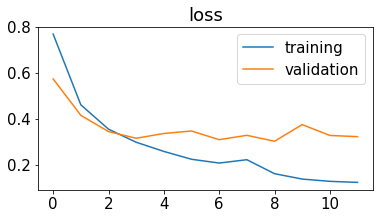

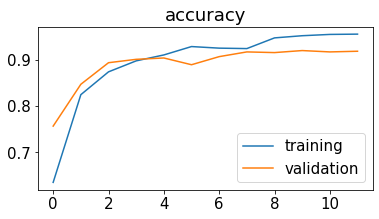

In [145]:
plot_loss(history_vgg16)

plot_accuracy(history_vgg16)

scores_vgg16 = model_vgg16.evaluate(X_test, y_test, verbose=2)

test accuracy: 91.56%
22/22 [==============================] - 49s 2s/step


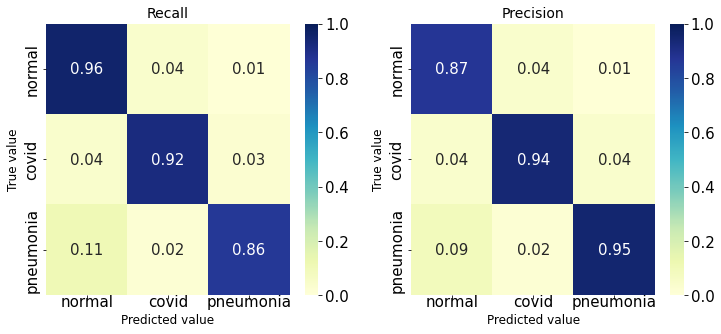

In [146]:
# Accuracy 
print('test %s: %.2f%%' % (model_vgg16.metrics_names[1], scores_vgg16[1]*100))
accuracy_vgg16 = np.round(scores_vgg16[1]*100)

# Confusion matrix: Recall vs. Precision
conf_matrix(model_vgg16, X_test, y_test)

In [147]:
# Temporal complexity measures
time_vgg16 = time_callback.times
time_vgg16_per_epoch = np.round(np.mean(time_vgg16))
time_vgg16_total = np.round(np.sum(time_vgg16))

print('Running time:', time_vgg16_per_epoch, 'seconds per epoch')
print('Total running time:', time_vgg16_total, 'seconds for', len(history_vgg16.epoch), 'epochs')

Running time: 946.0 seconds per epoch
Total running time: 11347.0 seconds for 12 epochs


In [149]:
time_vgg16_s = pd.DataFrame(time_vgg16)
time_vgg16_csv = 'time_vgg16.csv'
with open(time_vgg16_csv, mode = 'w') as f:
    time_vgg16_s.to_csv(f)

In [150]:
recall_vgg16, precision_vgg16, f1_base_vgg16 = performance_measures(model_vgg16, X_test, y_test)

22/22 [==============================] - 45s 2s/step
Recall score: 91.38%
Precision score: 92.03%
F1 score: 91.56%


### CNN-RNN with LSTM

In [61]:
earlystop = EarlyStopping(monitor='val_loss',
                          patience=3,
                          verbose=1,
                          min_delta=0.0005,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=2,
                              verbose=1,
                              mode='max',
                              min_lr=5e-15)

model_checkpoint = ModelCheckpoint(filepath='/tmp/checkpoint',
                                  save_weights_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  save_best_only=True)

time_callback = TimeHistory()

n_epochs = 30
batch_size = 32
num_classes = 3

In [99]:
# Loading model - in order to skip the training

# Load json
json_file = open(os.path.join(path, 'Model_lstm.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
model_lstm = model_from_json(loaded_model_json)

# Load weights
model_lstm.load_weights(os.path.join(path, 'Model_lstm.h5'))

# Compile model
model_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summary of the model
print(model_lstm.summary())

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_119 (Conv2D)         (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_120 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_121 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 32, 32, 64)     

In [62]:
callbacks_lstm = [earlystop, reduce_lr, model_checkpoint, time_callback]

In [90]:
model_lstm = models.Sequential([
    layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(256,256,3)),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    layers.Reshape((64, 64)),
    layers.LSTM(64),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_classes)])

print(model_lstm.summary())

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_119 (Conv2D)         (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_120 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_121 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 32, 32, 64)     

In [91]:
model_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
history_lstm = model_lstm.fit(X_train, y_train, 
                              epochs = n_epochs,
                              callbacks = callbacks_lstm,
                              batch_size = batch_size,
                              validation_data=(X_val, y_val))

Epoch 1/30
101/101 [==============================] - 107s 1s/step - loss: 1.0902 - accuracy: 0.3745 - val_loss: 1.0854 - val_accuracy: 0.3834 - lr: 1.0000e-04
Epoch 2/30
101/101 [==============================] - 138s 1s/step - loss: 0.9829 - accuracy: 0.5525 - val_loss: 0.8680 - val_accuracy: 0.6341 - lr: 1.0000e-04
Epoch 3/30
101/101 [==============================] - 136s 1s/step - loss: 0.8507 - accuracy: 0.6309 - val_loss: 0.7580 - val_accuracy: 0.6895 - lr: 1.0000e-04
Epoch 4/30
101/101 [==============================] - 119s 1s/step - loss: 0.7621 - accuracy: 0.6721 - val_loss: 0.6999 - val_accuracy: 0.7230 - lr: 1.0000e-04
Epoch 5/30
101/101 [==============================] - 111s 1s/step - loss: 0.6594 - accuracy: 0.7389 - val_loss: 0.5712 - val_accuracy: 0.7813 - lr: 1.0000e-04
Epoch 6/30
101/101 [==============================] - 108s 1s/step - loss: 0.5647 - accuracy: 0.7911 - val_loss: 0.5102 - val_accuracy: 0.8309 - lr: 1.0000e-04
Epoch 7/30
101/101 [====================

In [93]:
# SAVE MODEL

model_json = model_lstm.to_json()
with open(os.path.join(path, 'Model_lstm.json'), "w") as json_file:
     json_file.write(model_json)

model_lstm.save_weights(os.path.join(path, 'Model_lstm.h5'))

print("Model Saved")

Model Saved


In [115]:
hist_lstm = pd.DataFrame(history_lstm.history)
hist_lstm_csv = 'hist_lstm.csv'
with open(hist_lstm_csv, mode = 'w') as f:
    hist_lstm.to_csv(f)

22/22 - 5s - loss: 0.3015 - accuracy: 0.8967 - 5s/epoch - 242ms/step


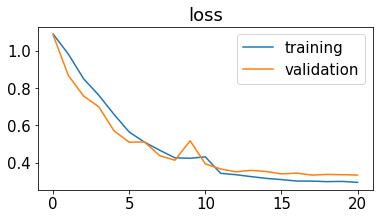

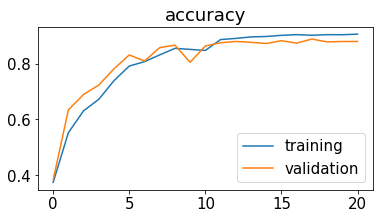

In [94]:
plot_loss(history_lstm)

plot_accuracy(history_lstm)

scores_lstm = model_lstm.evaluate(X_test, y_test, verbose=2)

In [98]:
# Temporal complexity measures
time_lstm = time_callback.times
time_lstm_per_epoch = np.round(np.mean(time_lstm))
time_lstm_total = np.round(np.sum(time_lstm))

print('Running time:', time_lstm_per_epoch, 'seconds per epoch')
print('Total running time:', time_lstm_total, 'seconds for', len(history_lstm.epoch), 'epochs')

Running time: 115.0 seconds per epoch
Total running time: 2416.0 seconds for 21 epochs


In [116]:
time_lstm = pd.DataFrame(time_lstm)
time_lstm_csv = 'time_lstm.csv'
with open(time_lstm_csv, mode = 'w') as f:
    time_lstm.to_csv(f)

test accuracy: 89.67%
22/22 [==============================] - 6s 241ms/step


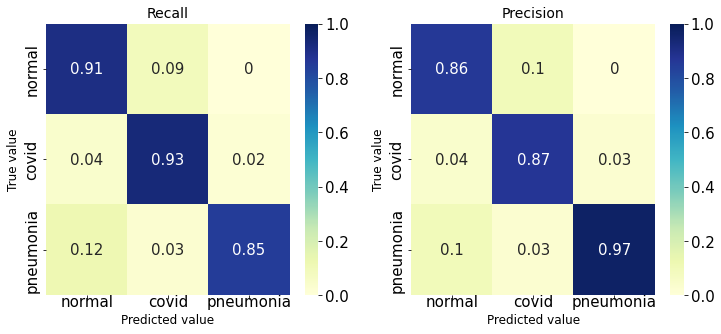

In [96]:
# Accuracy 
print('test %s: %.2f%%' % (model_lstm.metrics_names[1], scores_lstm[1]*100))
accuracy_lstm = np.round(scores_lstm[1]*100)

# Confusion matrix: Recall vs. Precision
conf_matrix(model_lstm, X_test, y_test)

In [152]:
recall_lstm, precision_lstm, f1_base_lstm = performance_measures(model_lstm, X_test, y_test)

22/22 [==============================] - 5s 208ms/step
Recall score: 89.60%
Precision score: 90.29%
F1 score: 89.75%


## Models' Comparison

In [215]:
# full time 
time_total = [time_base_total, time_base_aug_total, time_alexnet_total, time_vgg16_total, time_lstm_total] # array for barh

time_per_epoch = [time_base_per_epoch, time_base_aug_per_epoch, time_alexnet_per_epoch, time_vgg16_per_epoch, time_lstm_per_epoch] # arrays for plot
# accuracy
accuracy_array = [accuracy_base, accuracy_base_aug, accuracy_alexnet, accuracy_vgg16, accuracy_lstm] # arrays for bar
recall_array = np.dot([recall_base, recall_base_aug, recall_alexnet, recall_vgg16, recall_lstm], 100)
precision_array = np.dot([precision_base, precision_base_aug, precision_alexnet, precision_vgg16, precision_lstm], 100)
f1_array = np.dot([f1_base, f1_base_aug, f1_alexnet, f1_base_vgg16, f1_base_lstm], 100)

In [313]:
lab = ['Base', 'Base Aug', 'AlexNet', 'VGG16', 'CNN-LSTM']

#### Performace Measures

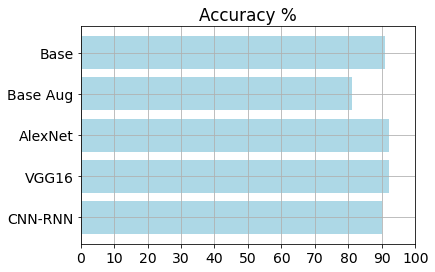

In [155]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.barh(lab, accuracy_array,  color = 'lightblue')
ax.set_title('Accuracy %')
ax.grid(True)
ax.invert_yaxis()
plt.xticks(np.arange(0, 110, 10)) 
plt.show()

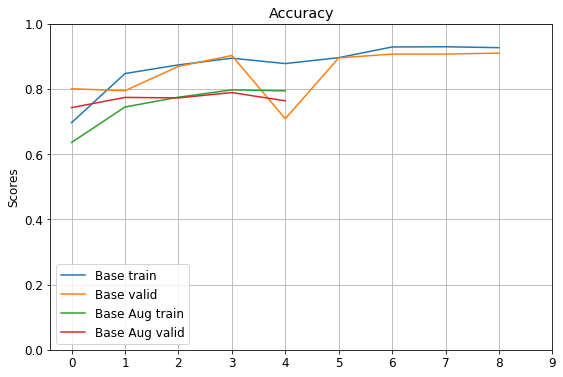

In [225]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(9,6))
plt.plot(history_base.epoch,history_base.history['accuracy'])
plt.plot(history_base.epoch,history_base.history['val_accuracy'])
plt.plot(history_base_aug.epoch,history_base_aug.history['accuracy'])
plt.plot(history_base_aug.epoch,history_base_aug.history['val_accuracy'])
plt.grid(True)
plt.title('Accuracy')
plt.ylabel('Scores')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xticks(np.arange(0, 10, 1))
plt.legend(['Base train', 'Base valid', 'Base Aug train', 'Base Aug valid'])
plt.show()

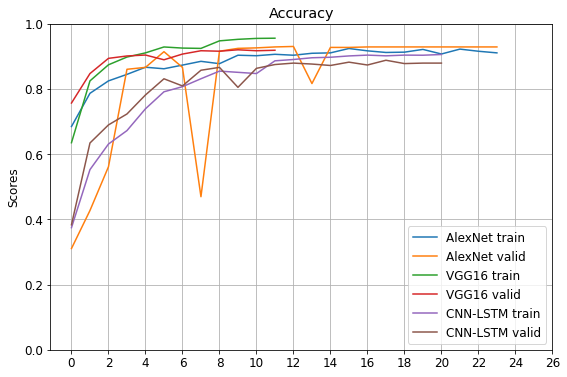

In [311]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(9,6))
plt.plot(history_alexnet.epoch,history_alexnet.history['accuracy'])
plt.plot(history_alexnet.epoch,history_alexnet.history['val_accuracy'])
plt.plot(history_vgg16.epoch,history_vgg16.history['accuracy'])
plt.plot(history_vgg16.epoch,history_vgg16.history['val_accuracy'])
plt.plot(history_lstm.epoch,history_lstm.history['accuracy'])
plt.plot(history_lstm.epoch,history_lstm.history['val_accuracy'])
plt.grid(True)
plt.title('Accuracy')
plt.ylabel('Scores')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xticks(np.arange(0, 28, 2))
plt.legend(['AlexNet train', 'AlexNet valid', 'VGG16 train', 'VGG16 valid', 'CNN-LSTM train', 'CNN-LSTM valid'])
plt.show()

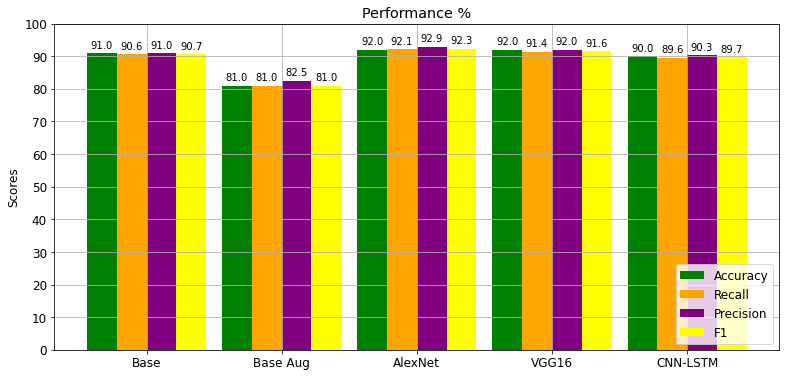

In [306]:
matplotlib.rcParams.update({'font.size': 12})
x = np.arange(5)
width = 0.22
fig, ax = plt.subplots(figsize=(13,6))
rects1 = ax.bar(x - width, accuracy_array, width, color = 'green', label='Accuracy')
rects2 = ax.bar(x, np.round(recall_array, 1), width, color = 'orange', label='Recall')
rects3 = ax.bar(x + width, np.round(precision_array, 1), width, color = 'purple', label='Precision')
rects4 = ax.bar(x + 2*width, np.round(f1_array, 1), width, color = 'yellow', label='F1')
for v in rects1:
    height = v.get_height()
    ax.annotate('{}'.format(height),
                xy=(v.get_x() + v.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize = 10)
for v in rects2:
    height = v.get_height()
    ax.annotate('{}'.format(height),
                xy=(v.get_x() + v.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize = 10)    
for v in rects3:
    height = v.get_height()
    ax.annotate('{}'.format(height),
                xy=(v.get_x() + v.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize = 10)
for v in rects4:
    height = v.get_height()
    ax.annotate('{}'.format(height),
                xy=(v.get_x() + v.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize = 10)
ax.set_title('Performance %')
ax.set_ylabel('Scores')
ax.grid(True)
plt.yticks(np.arange(0, 110, 10)) 
plt.xticks(x + width/2, lab)
plt.legend(['Accuracy', 'Recall', 'Precision', 'F1'], loc ='lower right')
plt.show()

#### Temporal Complexity

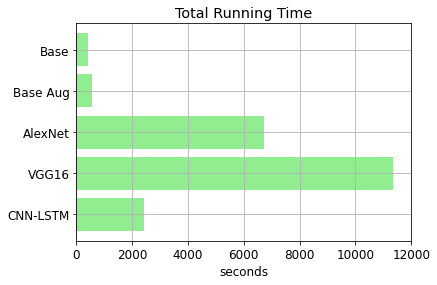

In [314]:
# Total RT
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
ax.barh(lab, time_total, color = 'lightgreen')
ax.set_xlabel('seconds')
ax.set_title('Total Running Time')
ax.invert_yaxis()
ax.grid(True)
plt.xticks(np.arange(0, 13000, 2000))
plt.show()

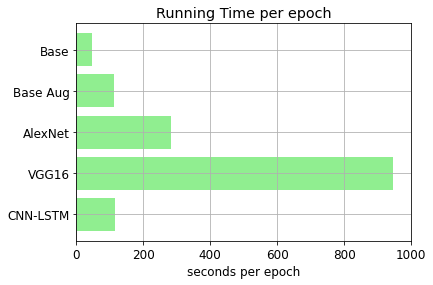

In [315]:
# RT per epoch
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
ax.barh(lab, time_per_epoch, color = 'lightgreen')
ax.set_xlabel('seconds per epoch')
ax.set_title('Running Time per epoch')
ax.invert_yaxis()
ax.grid(True)
plt.xticks(np.arange(0, 1200, 200)) 
plt.show()

## Effects of contrasting

### Contrast Stretching

In [316]:
# Applying contrast stretching
X_train_cs = contrasting(X_train, contrast_stretching)
X_val_cs = contrasting(X_val, contrast_stretching)
X_test_cs = contrasting(X_test, contrast_stretching)

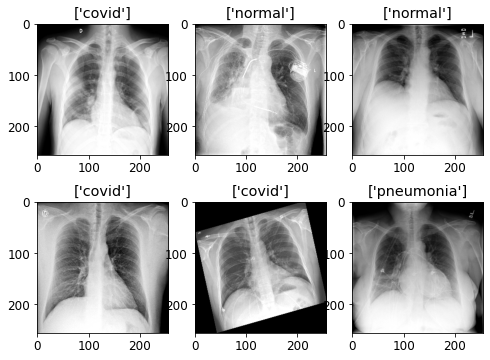

In [279]:
show_img(X_train_cs, y_train_labels)

In [228]:
model_alexnet_cs = models.Sequential([
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

print(model_alexnet_cs.summary())

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_143 (Conv2D)         (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 62, 62, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_144 (Conv2D)         (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                     

In [229]:
model_alexnet_cs.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.optimizers.SGD(learning_rate=0.001), 
              metrics=['accuracy'])

In [230]:
history_alexnet_cs = model_alexnet_cs.fit(X_train_cs, y_train,
                      batch_size = batch_size,
                      epochs = n_epochs,
                      callbacks = callbacks_alexnet,
                      validation_data = (X_val_cs, y_val))

Epoch 1/30
101/101 [==============================] - 322s 3s/step - loss: 1.1291 - accuracy: 0.6914 - val_loss: 1.0378 - val_accuracy: 0.5131 - lr: 0.0010
Epoch 2/30
101/101 [==============================] - 280s 3s/step - loss: 0.7405 - accuracy: 0.7764 - val_loss: 1.2372 - val_accuracy: 0.3790 - lr: 0.0010
Epoch 3/30
101/101 [==============================] - 272s 3s/step - loss: 0.5340 - accuracy: 0.8307 - val_loss: 1.4629 - val_accuracy: 0.5437 - lr: 0.0010
Epoch 4/30
101/101 [==============================] - 260s 3s/step - loss: 0.5358 - accuracy: 0.8264 - val_loss: 0.4452 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 5/30
101/101 [==============================] - 256s 3s/step - loss: 0.4455 - accuracy: 0.8551 - val_loss: 0.5884 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 6/30
101/101 [==============================] - 257s 3s/step - loss: 0.4289 - accuracy: 0.8554 - val_loss: 0.3119 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 7/30
101/101 [==============================] - 257s 3s/st

In [233]:
hist_alexnet_cs = pd.DataFrame(history_alexnet_cs.history)
hist_alexnet_cs_csv = 'hist_alexnet.csv'
with open(hist_alexnet_cs_csv, mode = 'w') as f:
    hist_alexnet_cs.to_csv(f)

22/22 - 11s - loss: 0.2870 - accuracy: 0.9112 - 11s/epoch - 510ms/step


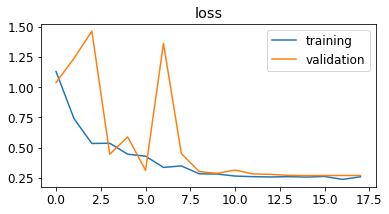

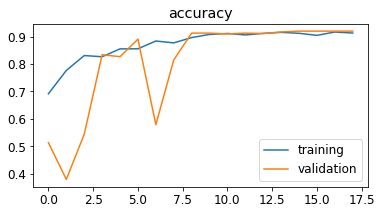

In [232]:
plot_loss(history_alexnet_cs)

plot_accuracy(history_alexnet_cs)

scores_alexnet_cs = model_alexnet_cs.evaluate(X_test_cs, y_test, verbose=2)

In [234]:
# Temporal complexity measures
time_alexnet_cs = time_callback.times
time_alexnet_cs_per_epoch = np.round(np.mean(time_alexnet_cs))
time_alexnet_cs_total = np.round(np.sum(time_alexnet_cs))

print('Running time:', time_alexnet_cs_per_epoch, 'seconds per epoch')
print('Total running time:', time_alexnet_cs_total, 'seconds for', len(history_alexnet_cs.epoch), 'epochs')

Running time: 946.0 seconds per epoch
Total running time: 11347.0 seconds for 18 epochs


test accuracy: 91.12%
22/22 [==============================] - 11s 505ms/step


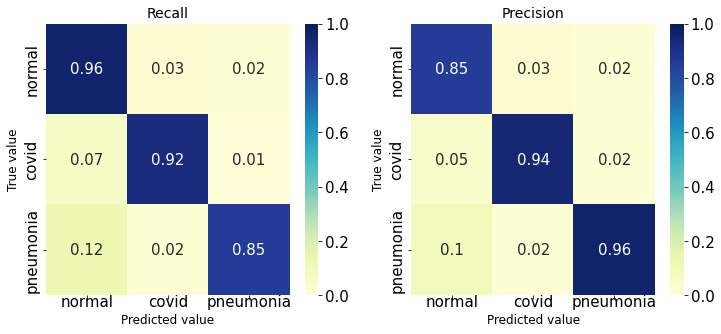

In [235]:
# Accuracy 
print('test %s: %.2f%%' % (model_alexnet_cs.metrics_names[1], scores_alexnet_cs[1]*100))
accuracy_alexnet_cs = np.round(scores_alexnet_cs[1]*100)

# Confusion matrix: Recall vs. Precision
conf_matrix(model_alexnet_cs, X_test_cs, y_test)

In [236]:
recall_alexnet_cs, precision_alexnet_cs, f1_alexnet_cs = performance_measures(model_alexnet_cs, X_test_cs, y_test)

22/22 [==============================] - 13s 603ms/step
Recall score: 90.93%
Precision score: 91.89%
F1 score: 91.19%


### Histogram Equalization

In [317]:
# Applying histogram equalization
X_train_he = contrasting(X_train, hist_equalization)
X_val_he = contrasting(X_val, hist_equalization)
X_test_he = contrasting(X_test, hist_equalization)

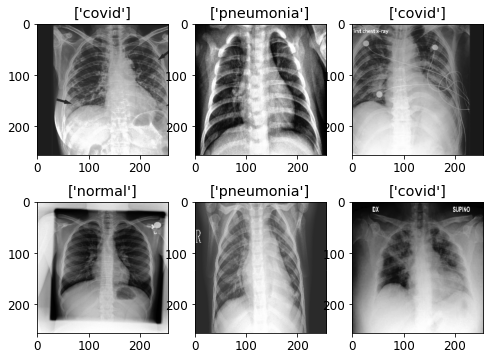

In [280]:
show_img(X_train_he, y_train_labels)

In [239]:
model_alexnet_he = models.Sequential([
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

print(model_alexnet_he.summary())

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_148 (Conv2D)         (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 62, 62, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_149 (Conv2D)         (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 30, 30, 256)      1024      
 chNormalization)                                                
                                                     

In [240]:
model_alexnet_he.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.optimizers.SGD(learning_rate=0.001), 
              metrics=['accuracy'])

In [241]:
history_alexnet_he = model_alexnet_he.fit(X_train_he, y_train,
                      batch_size = batch_size,
                      epochs = n_epochs,
                      callbacks = callbacks_alexnet,
                      validation_data = (X_val_he, y_val))

Epoch 1/30
101/101 [==============================] - 325s 3s/step - loss: 1.1843 - accuracy: 0.6758 - val_loss: 1.0642 - val_accuracy: 0.3367 - lr: 0.0010
Epoch 2/30
101/101 [==============================] - 321s 3s/step - loss: 0.6710 - accuracy: 0.7967 - val_loss: 1.0472 - val_accuracy: 0.3411 - lr: 0.0010
Epoch 3/30
101/101 [==============================] - 313s 3s/step - loss: 0.6200 - accuracy: 0.8051 - val_loss: 0.9462 - val_accuracy: 0.5146 - lr: 0.0010
Epoch 4/30
101/101 [==============================] - 309s 3s/step - loss: 0.4667 - accuracy: 0.8410 - val_loss: 0.4249 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 5/30
101/101 [==============================] - 304s 3s/step - loss: 0.4322 - accuracy: 0.8579 - val_loss: 0.3877 - val_accuracy: 0.8601 - lr: 0.0010
Epoch 6/30
101/101 [==============================] - 312s 3s/step - loss: 0.3772 - accuracy: 0.8676 - val_loss: 0.3994 - val_accuracy: 0.8761 - lr: 0.0010
Epoch 7/30
101/101 [==============================] - 292s 3s/st

In [242]:
hist_alexnet_he = pd.DataFrame(history_alexnet_he.history)
hist_alexnet_he_csv = 'hist_alexnet_he.csv'
with open(hist_alexnet_he_csv, mode = 'w') as f:
    hist_alexnet_he.to_csv(f)

22/22 - 10s - loss: 0.2378 - accuracy: 0.9287 - 10s/epoch - 452ms/step


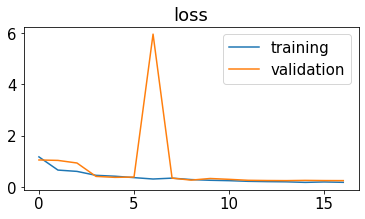

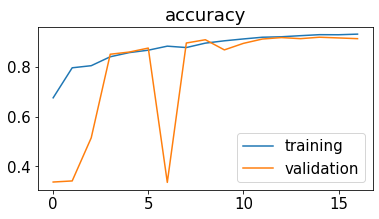

In [244]:
plot_loss(history_alexnet_he)

plot_accuracy(history_alexnet_he)

scores_alexnet_he = model_alexnet_he.evaluate(X_test_he, y_test, verbose=2)

In [245]:
# Temporal complexity measures
time_alexnet_he = time_callback.times
time_alexnet_he_per_epoch = np.round(np.mean(time_alexnet_he))
time_alexnet_he_total = np.round(np.sum(time_alexnet_he))

print('Running time:', time_alexnet_he_per_epoch, 'seconds per epoch')
print('Total running time:', time_alexnet_he_total, 'seconds for', len(history_alexnet_he.epoch), 'epochs')

Running time: 946.0 seconds per epoch
Total running time: 11347.0 seconds for 17 epochs


test accuracy: 92.87%
22/22 [==============================] - 11s 496ms/step


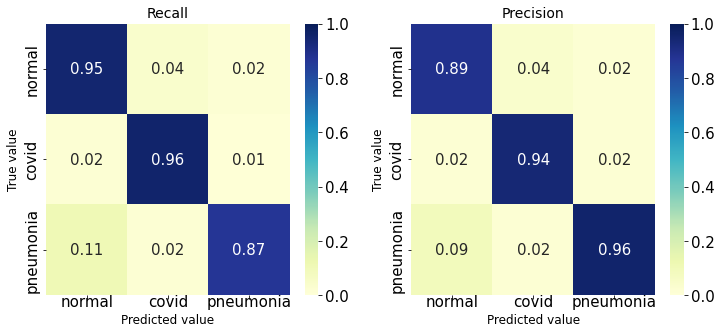

In [246]:
# Accuracy 
print('test %s: %.2f%%' % (model_alexnet_he.metrics_names[1], scores_alexnet_he[1]*100))
accuracy_alexnet_he = np.round(scores_alexnet_he[1]*100)

# Confusion matrix: Recall vs. Precision
conf_matrix(model_alexnet_he, X_test_he, y_test)

In [247]:
recall_alexnet_he, precision_alexnet_he, f1_alexnet_he = performance_measures(model_alexnet_he, X_test_he, y_test)

22/22 [==============================] - 12s 553ms/step
Recall score: 92.76%
Precision score: 93.20%
F1 score: 92.87%


### Adaptive Equalization

In [318]:
# Applying adaptive equalization
X_train_ae = contrasting(X_train, adaptive_equalization)
X_val_ae = contrasting(X_val, adaptive_equalization)
X_test_ae = contrasting(X_test, adaptive_equalization)

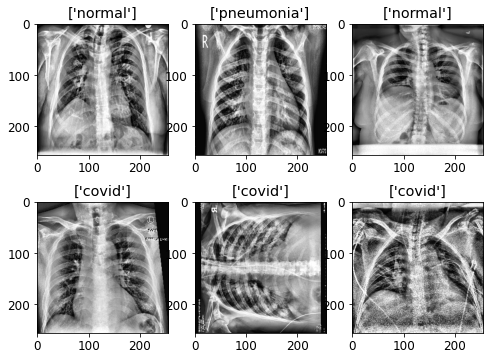

In [281]:
show_img(X_train_ae, y_train_labels)

In [249]:
model_alexnet_ae = models.Sequential([
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

print(model_alexnet_ae.summary())

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_153 (Conv2D)         (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization_15 (Bat  (None, 62, 62, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_154 (Conv2D)         (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_16 (Bat  (None, 30, 30, 256)      1024      
 chNormalization)                                                
                                                     

In [250]:
model_alexnet_ae.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.optimizers.SGD(learning_rate=0.001), 
              metrics=['accuracy'])

In [251]:
history_alexnet_ae = model_alexnet_ae.fit(X_train_ae, y_train,
                      batch_size = batch_size,
                      epochs = n_epochs,
                      callbacks = callbacks_alexnet,
                      validation_data = (X_val_ae, y_val))

Epoch 1/30
101/101 [==============================] - 281s 3s/step - loss: 1.3075 - accuracy: 0.6602 - val_loss: 1.1408 - val_accuracy: 0.3353 - lr: 0.0010
Epoch 2/30
101/101 [==============================] - 253s 3s/step - loss: 0.7364 - accuracy: 0.7776 - val_loss: 1.3612 - val_accuracy: 0.3353 - lr: 0.0010
Epoch 3/30
101/101 [==============================] - 249s 2s/step - loss: 0.5571 - accuracy: 0.8186 - val_loss: 0.9322 - val_accuracy: 0.4679 - lr: 0.0010
Epoch 4/30
101/101 [==============================] - 248s 2s/step - loss: 0.4614 - accuracy: 0.8592 - val_loss: 0.4044 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 5/30
101/101 [==============================] - 246s 2s/step - loss: 0.4067 - accuracy: 0.8654 - val_loss: 0.6152 - val_accuracy: 0.6924 - lr: 0.0010
Epoch 6/30
101/101 [==============================] - 246s 2s/step - loss: 0.3897 - accuracy: 0.8688 - val_loss: 0.2956 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 7/30
101/101 [==============================] - 247s 2s/st

In [263]:
hist_alexnet_ae = pd.DataFrame(history_alexnet_ae.history)
hist_alexnet_ae_csv = 'hist_alexnet_ae.csv'
with open(hist_alexnet_ae_csv, mode = 'w') as f:
    hist_alexnet_ae.to_csv(f)

22/22 - 8s - loss: 0.2555 - accuracy: 0.9287 - 8s/epoch - 383ms/step


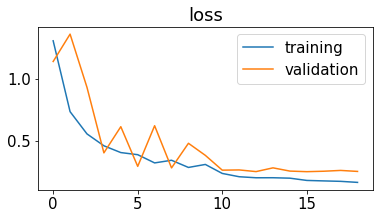

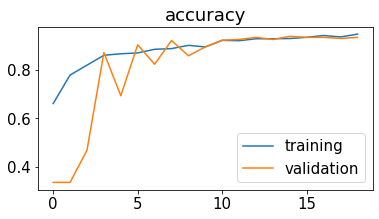

In [252]:
plot_loss(history_alexnet_ae)

plot_accuracy(history_alexnet_ae)

scores_alexnet_ae = model_alexnet_ae.evaluate(X_test_ae, y_test, verbose=2)

In [253]:
# Temporal complexity measures
time_alexnet_ae = time_callback.times
time_alexnet_ae_per_epoch = np.round(np.mean(time_alexnet_ae))
time_alexnet_ae_total = np.round(np.sum(time_alexnet_ae))

print('Running time:', time_alexnet_ae_per_epoch, 'seconds per epoch')
print('Total running time:', time_alexnet_ae_total, 'seconds for', len(history_alexnet_ae.epoch), 'epochs')

Running time: 946.0 seconds per epoch
Total running time: 11347.0 seconds for 19 epochs


test accuracy: 92.87%
22/22 [==============================] - 10s 441ms/step


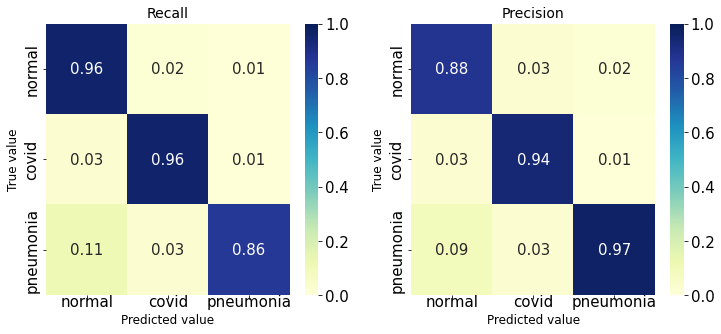

In [254]:
# Accuracy 
print('test %s: %.2f%%' % (model_alexnet_ae.metrics_names[1], scores_alexnet_ae[1]*100))
accuracy_alexnet_ae = np.round(scores_alexnet_ae[1]*100)

# Confusion matrix: Recall vs. Precision
conf_matrix(model_alexnet_ae, X_test_ae, y_test)

In [255]:
recall_alexnet_ae, precision_alexnet_ae, f1_alexnet_ae = performance_measures(model_alexnet_ae, X_test_ae, y_test)

22/22 [==============================] - 11s 523ms/step
Recall score: 92.70%
Precision score: 93.37%
F1 score: 92.85%


### Comparison

In [256]:
accuracy_con = [accuracy_alexnet, accuracy_alexnet_cs, accuracy_alexnet_he, accuracy_alexnet_ae]
recall_con = np.dot([recall_alexnet, recall_alexnet_cs, recall_alexnet_he, recall_alexnet_ae], 100)
precision_con = np.dot([precision_alexnet, precision_alexnet_cs, precision_alexnet_he, precision_alexnet_ae], 100)
f1_con = np.dot([f1_alexnet, f1_alexnet_cs, f1_alexnet_he, f1_alexnet_ae], 100)

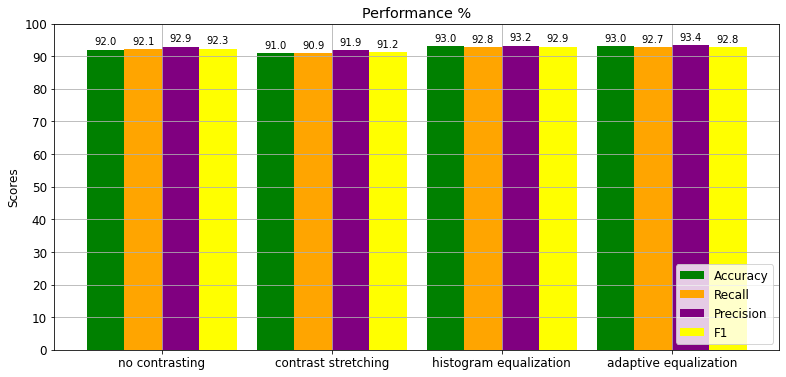

In [261]:
matplotlib.rcParams.update({'font.size': 12})
x = np.arange(4)
width = 0.22
fig, ax = plt.subplots(figsize=(13,6))
rects1 = ax.bar(x - width, accuracy_con, width, color = 'green', label='Accuracy')
rects2 = ax.bar(x, np.round(recall_con, 1), width, color = 'orange', label='Recall')
rects3 = ax.bar(x + width, np.round(precision_con, 1), width, color = 'purple', label='Precision')
rects4 = ax.bar(x + 2*width, np.round(f1_con, 1), width, color = 'yellow', label='F1')
for v in rects1:
    height = v.get_height()
    ax.annotate('{}'.format(height),
                xy=(v.get_x() + v.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize = 10)
for v in rects2:
    height = v.get_height()
    ax.annotate('{}'.format(height),
                xy=(v.get_x() + v.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize = 10)    
for v in rects3:
    height = v.get_height()
    ax.annotate('{}'.format(height),
                xy=(v.get_x() + v.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize = 10)
for v in rects4:
    height = v.get_height()
    ax.annotate('{}'.format(height),
                xy=(v.get_x() + v.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize = 10)
ax.set_title('Performance %')
ax.set_ylabel('Scores')
ax.grid(True)
plt.yticks(np.arange(0, 110, 10)) 
plt.xticks(x + width/2, ('no contrasting', 'contrast stretching', 'histogram equalization', 'adaptive equalization'))
plt.legend(['Accuracy', 'Recall', 'Precision', 'F1'], loc ='lower right')
plt.show()